In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [48]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
# first check current device that tensor computations will run on (recommended GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device >>>>>>>>",device)

Device >>>>>>>> cuda:0


In [49]:
# initialize dataset object
img_size=32
batch_size=64
transform = transforms.Compose([
        transforms.Scale(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5))
])
dataset = torchvision.datasets.FashionMNIST(root='data/', train=True, transform=transform, download=True)
print(dataset)

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               Scale(size=32, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


In [50]:
# invoke dataloader object to load and yield samples from the dataset
# Data loader. Combines a dataset and a sampler, and provides an iterable over the given dataset.
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)

label >>>> 4
label >>>> 1
label >>>> 8
label >>>> 4
label >>>> 5
label >>>> 9
label >>>> 5
label >>>> 2


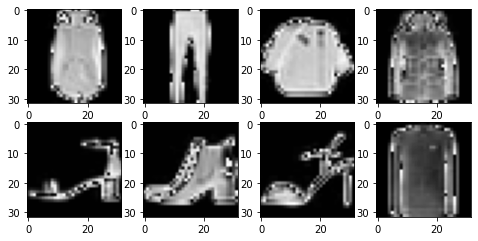

In [51]:
# plot samples of the dataset
fig=plt.figure(figsize=(8, 8))
rows=4
cols=4
ldr=iter(dataloader)
for i in range(1,9):
    img,label=next(ldr)
    fig.add_subplot(rows, cols, i)
    idx=np.random.randint(low=0,high=64,size=1)
    plt.imshow(transforms.ToPILImage()(torch.squeeze(img[idx])),cmap="gray") # transform tensor to PIL image
    print("label >>>>",label[idx].item())

In [52]:
# utils
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [53]:
class PreGeneratorHiddenLayers(nn.Module):
    """
    class implements the hidden layer before generation done
    """
    def __init__(self,dimin,dimout,kernel=4,stride=1):
        super().__init__()
        self.dimin=dimin
        self.dimout=dimout
        self.kernel=kernel
        self.stride=stride
        self.net=nn.Sequential(
            nn.ConvTranspose2d(self.dimin,self.dimout,self.kernel,self.stride),
            nn.BatchNorm2d(self.dimout),
            nn.ReLU(inplace=True)
        )
    
    def forward(self,input_noise_z):
        return self.net.forward(input_noise_z)

class PreDiscriminatorHiddenLayers(nn.Module):
    """
    class implements the hidden layer before generation done
    """
    def __init__(self,dimin=10,dimout=64,kernel=4,stride=2,padding=1):
        super().__init__()
        self.dimin=dimin
        self.dimout=dimout
        self.kernel=kernel
        self.stride=stride
        self.padding=padding
        self.net=nn.Sequential(
            nn.Conv2d(self.dimin,self.dimout,self.kernel,self.stride,self.padding),
            nn.LeakyReLU(inplace=True)
        )
    
    def forward(self,label):
        return self.net.forward(label)

In [54]:
# Generator network
class Generator(nn.Module):
    def __init__(self,input_filters=512,out_filters=256):
        self.input_filters=input_filters
        self.out_filters=out_filters
        super().__init__()
        self.net=nn.Sequential(
            # generator receives tensor with 512 filters each of 4*4
            nn.ConvTranspose2d(in_channels=self.input_filters,out_channels=self.out_filters,kernel_size=4,stride =2 , padding=1,bias=False),
            # out now is >>>> (256,8,8)
            nn.BatchNorm2d(self.out_filters),
            nn.LeakyReLU(0.2,inplace=True),
            # out now is >>>> (256,8,8) batch normed and activated with Relu
            nn.ConvTranspose2d(in_channels=self.out_filters, out_channels=self.out_filters//2, kernel_size=4, stride=2,padding=1,bias=False),
            nn.BatchNorm2d(self.out_filters//2),
            nn.LeakyReLU(0.2,inplace=True),
            # out now 128 x 16 x 16 batch normed and activated with Relu
            nn.ConvTranspose2d(in_channels=self.out_filters//2, out_channels=1 , kernel_size=4, stride=2,padding=1,bias=False),
            nn.Tanh()
            # out now 1 x 32 x 32 Tanh activated
        )
        
    def forward(self, input_tensor):
        return self.net.forward(input_tensor)

# Discriminator network
class Discriminator(nn.Module):
    def __init__(self,input_filters=128,out_filters=256):
        self.input_filters=input_filters
        self.out_filters=out_filters
        super().__init__()
        self.net = nn.Sequential(
            # input is (128) x 16 x 16
            nn.Conv2d(self.input_filters, self.out_filters, kernel_size=4, stride=2,padding=1,bias=False),
            nn.BatchNorm2d(self.out_filters),
            nn.LeakyReLU(0.2, inplace=True),
            # result now (256) x 8 x 8
            nn.Conv2d(self.out_filters, self.out_filters * 2, kernel_size=4, stride=2,padding=1,bias=False),
            nn.BatchNorm2d(self.out_filters * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # result now (512) x 4 x 4
            nn.Conv2d(self.out_filters * 2, 1, kernel_size=4, stride=1,padding=0,bias=False),
            nn.Sigmoid() # real or fake node
        )

    def forward(self, input_tensor):
        return self.net.forward(input_tensor)

In [55]:
netG=Generator().to(device)
netG.apply(weights_init)

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)

In [56]:
netD=Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (net): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (7): Sigmoid()
  )
)

In [57]:
predisc1=PreDiscriminatorHiddenLayers(dimin=10,dimout=64).to(device)
predisc1.apply(weights_init)
predisc2=PreDiscriminatorHiddenLayers(dimin=1,dimout=64).to(device)
predisc2.apply(weights_init)

PreDiscriminatorHiddenLayers(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
  )
)

In [58]:
pregen1=PreGeneratorHiddenLayers(dimin=100,dimout=256).to(device)
pregen1.apply(weights_init)
pregen2=PreGeneratorHiddenLayers(dimin=10,dimout=256).to(device)
pregen2.apply(weights_init)

PreGeneratorHiddenLayers(
  (net): Sequential(
    (0): ConvTranspose2d(10, 256, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
)

In [59]:
# Define loss and optimization
# Initialize BCELoss function
criterion = nn.BCELoss()

# Setup SGD optimizers for both G and D
optimizerD = torch.optim.SGD(netD.parameters(), lr=0.0002)
optimizerG = torch.optim.SGD(netG.parameters(), lr=0.0002)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

In [60]:
# Training Loop
# Lists to keep track of progress
G_losses = []
D_losses = []

# training parameters
num_epochs = 20

# data arameters
ncls=10
noisedim=100

#labels
rlabel = torch.full((batch_size,), real_label).to(device)
flabel = torch.full((batch_size,), fake_label).to(device)
yf = torch.zeros(batch_size,ncls,1,1).to(device)
grlabel = torch.full((batch_size,), real_label).to(device) # generator sees its geenerated samples as real

print("Starting Training Loop >>>")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i,data in enumerate(dataloader):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        if data[0].shape[0]<batch_size:
            continue
        netD.zero_grad()
        predisc1.zero_grad()
        predisc2.zero_grad()
        # train with all real batch
        # encode numerical label into one hot vector
        # one hot vector for label
        y = torch.zeros(batch_size,ncls,1,1).to(device)
        for x,l in enumerate(data[1]):
            y[x,l.item(),:,:]=1.0
        # expnad y dimentions
        y=y.expand(-1,-1,32,32)
        # feed (batch_size,ncls,32,32) tensor to pre-discriminator network
        input_d_part1 = predisc1(y)
        # feed (batch_size,1,32,32) (image) tensor to pre-discriminator network
        input_d_part2 = predisc2(data[0].to(device))
        # concat part1 ,part2
        merge1=torch.cat((input_d_part1,input_d_part2),1)
        # now merge is tensor with shape (batch_size,128,16,16)
        # next step >> forward merge to Discriminator
        netout1=netD(merge1)
        # compute loss
        errD_real=criterion(netout1,rlabel)
        # Calculate gradients for Discriminator in backward pass
        errD_real.backward(retain_graph=True)
        ## Train with all-fake batch
        noise = torch.randn(batch_size,noisedim , 1, 1).to(device)
        # feed noise tensor >>> (64,100,1,1) to pre-generator network
        gen_part1 = pregen1(noise)
        # now gen_part1 is tensor (batch_size,256,4,4)
        # generate random fake label
        yf[:,torch.randint(low=0,high=10,size=(1,)).item(),:,:]=1.0
        gen_part2=pregen2(yf)
        # now gen_part2 is tensor (batch_size,256,4,4)
        # concat the two tensors
        merge2=torch.cat((gen_part1,gen_part2),1)
        # forward merge2 tensor (batch_size,512,4,4)
        fake_sample = netG(merge2)
        # pass fake_sample (batc_size,1,32,32) to disriminator
        gen_input_d_part2 = predisc2(fake_sample)
        # gen_input_d_part2 >>> (batc_size,64,16,16)
        merge3=torch.cat((input_d_part1,gen_input_d_part2),1)
        netout2 = netD(merge3)
        # compute loss
        errD_fake = criterion(netout2,flabel)
        # Calculate gradients for Discriminator in backward pass
        errD_fake.backward(retain_graph=True)
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        
        netG.zero_grad()
        noise = torch.randn(batch_size,noisedim , 1, 1).to(device)
        # feed noise tensor >>> (64,100,1,1) to pre-generator network
        gen_part1 = pregen1(noise)
        # now gen_part1 is tensor (batch_size,256,4,4)
        # generate random fake label
        yf[:,torch.randint(low=0,high=10,size=(1,)).item(),:,:]=1.0
        yftod = yf
        yftod = yftod.expand(-1,-1,32,32)
        gen_input_d_part1 = predisc1(yftod)
        gen_part2 = pregen2(yf)
        # now gen_part2 is tensor (batch_size,256,4,4)
        # concat the two tensors
        merge2=torch.cat((gen_part1,gen_part2),1)
        # forward merge2 tensor (batch_size,512,4,4)
        fake_sample = netG(merge2)
        # pass fake_sample (batc_size,1,32,32) to disriminator
        gen_input_d_part2 = predisc2(fake_sample)
        # gen_input_d_part2 >>> (batc_size,64,16,16)
        merge3=torch.cat((gen_input_d_part1,gen_input_d_part2),1)
        netout2 = netD(merge3)
        errG = criterion(netout2,grlabel)
        errG.backward(retain_graph=True)
        optimizerG.step()
        
        # log errors
        if i%50==0:
            print("error D >>> ",errD)
            print("error G >>> ",errG)

Starting Training Loop >>>
error D >>>  tensor(1.9806, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(6.9799, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
error D >>>  tensor(100., device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(0., device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
error D >>>  tensor(1.9131, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(14.5468, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
error D >>>  tensor(3.7526, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(0.0010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
error D >>>  tensor(1.1479, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(22.2579, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
error D >>>  tensor(0.0680, device='cuda:0', grad_fn=<AddBackward0>)
error G >>>  tensor(5.3078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
error D >>>  tensor(0.0614, device='cuda:0', grad_fn=<AddBackward

RuntimeError: Sizes of tensors must match except in dimension 0. Got 32 and 64

In [63]:
noise = torch.randn(1,noisedim , 1, 1).cuda()
# feed noise tensor >>> (64,100,1,1) to pre-generator network
gen_part1 = pregen1(noise)
# now gen_part1 is tensor (batch_size,256,4,4)
# generate random fake label
yf = torch.zeros(1,ncls,1,1).cuda()
yf[:,8,:,:]=1.0 # supposed to add wanted class to be generated
gen_part2=pregen2(yf)
# now gen_part2 is tensor (batch_size,256,4,4)
# concat the two tensors
merge2=torch.cat((gen_part1,gen_part2),1)
# forward merge2 tensor (batch_size,512,4,4)
fake_sample = netG(merge2)

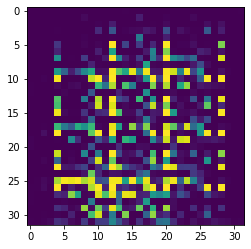

In [64]:
fake_sample.squeeze()
fake=fake_sample.cpu().detach().numpy()
fake=fake.squeeze()
plt.imshow(fake)